# Pneumonia Detection using X-Ray Images
<font size = 5> Hazem Mohamed Abdelghafar 211001615</font>


<font size = 8>What is Pneumonia?</font> <br><br>
<font size = 3><b> Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli. Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty in breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis. The disease may be classified by where it was acquired, such as community, hospital-acquired or healthcare-associated pneumonia.</b></font>

## Library imports 

In [10]:
%load_ext chime

import os
import chime
import random
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image 
from time import sleep
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization

from sklearn.metrics import classification_report, confusion_matrix


The chime extension is already loaded. To reload it, use:
  %reload_ext chime


In [11]:
chime.theme('zelda')
chime.notify_exceptions()

## Data Preprocessing

### Loading the Dataset

In [12]:
def load_imgs(path):
    return cv.imread(path, cv.IMREAD_GRAYSCALE)

In [13]:
training_set = ['./input/train','./input/test','./input/val']

labels = ['NORMAL', 'PNEUMONIA'] # 0 = Normal, 1 = Pneumonia

img_size = 500 # Number of pixels in each dimension

train_data = []
test_data = []
val_data = []

In [14]:
for x, data_dir in enumerate(training_set):
    for label in labels: 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            img_arr = load_imgs(os.path.join(path, img)) # Loading the images
            resized_arr = cv.resize(img_arr, (img_size, img_size)) /255 # Reshaping images to preferred size
            norm_image = cv.normalize(resized_arr, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F) # Normalizing the images from range [0,1]
            if x == 0:
                train_data.append([norm_image, label]) # Adding image array and label to the train_data list
            elif x == 1:
                test_data.append([norm_image, label]) # Adding image array and label to the test_data list
            elif x == 2:
                val_data.append([norm_image, label]) # Adding image array and label to the val_data list


In [15]:
train_df = pd.DataFrame(train_data, columns=['Image Matrix', 'Label'])
test_df = pd.DataFrame(test_data, columns=['Image Matrix', 'Label'])
val_df = pd.DataFrame(val_data, columns=['Image Matrix', 'Label'])

In [16]:
# Dataframes 
# Shuffling the dataframes to avoid bias
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)

In [23]:
train_df.sample(5)

,Image Matrix,Label
2449,"[[0.22352941, 0.23137255, 0.23137255, 0.243137...",PNEUMONIA
2990,"[[0.011764706, 0.011764706, 0.011764706, 0.011...",PNEUMONIA
3343,"[[0.52156866, 0.49019608, 0.4862745, 0.4745098...",NORMAL
1900,"[[0.050980393, 0.050980393, 0.050980393, 0.050...",PNEUMONIA
2106,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",PNEUMONIA


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Image Matrix  5216 non-null   object
 1   Label         5216 non-null   object
dtypes: object(2)
memory usage: 81.6+ KB


In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Image Matrix  624 non-null    object
 1   Label         624 non-null    object
dtypes: object(2)
memory usage: 9.9+ KB


In [20]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Image Matrix  16 non-null     object
 1   Label         16 non-null     object
dtypes: object(2)
memory usage: 388.0+ bytes


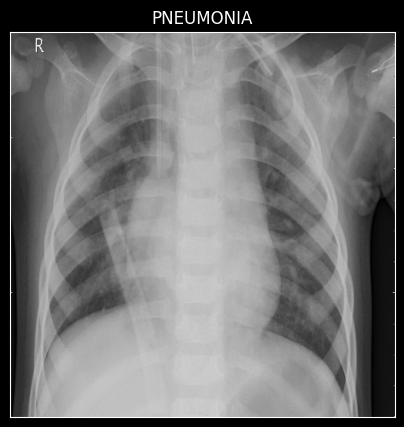

In [21]:
# Image example of the dataset
rand_num = random.randint(0, 5215)
plt.figure(figsize = (5,5))
plt.imshow(train_df['Image Matrix'][rand_num], cmap='gray')
plt.title(train_df['Label'][rand_num])
plt.xticks([])
plt.yticks([])
plt.show()

### Data Augmentation

In [26]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

train_images = np.array(train_df['Image Matrix'].tolist())

# Reshape train_images to have rank 4
train_images = train_images.reshape(-1, img_size, img_size, 1)

datagen.fit(train_images)

In [28]:
train_images.shape

(5216, 500, 500, 1)